# mean-field solver 

## Some background

### What is a mean field solver and why do we need it?

Solving many-body systems such as a hellium atom in chemistry ([reference I used here](https://adambaskerville.github.io/posts/HartreeFockGuide/)):

<p style="text-align:center;"><img src="https://adambaskerville.github.io/assets/img/HartreeFockInfographic.png" width="400"></p>

Why is it useful?
* If we tried to solve $N$ particles with $M$ distinct states exactly, the full Hilbert space is $M^N$. Mean-field maps into a much smaller non-interacting system of size $M N$
* Quantitative accuracy is either hit or miss, but gives a good understanding of the qualitative behaviour of the system.

### General idea through an example

#### The Ising model

Consider an Ising model:

<p style="text-align:center;"><img src="https://pbs.twimg.com/media/DKu31zYXcAECSDL.jpg" width="400"></p>

with the Hamiltonian (straight from [wikipedia](https://en.wikipedia.org/wiki/Mean-field_theory#Ising_model)):

$$
H=-J\sum _{\langle i,j\rangle }s_{i}s_{j}-h\sum _{i}s_{i}
$$

where $s_i$ is the spin of the $i$th particle, $J$ is the exchange coupling, and $h$ is the external magnetic field. The sum is over nearest neighbours.

#### Identifying and applying mean field

It is an interacting problem and thus a headache to solve. Rather than consider all the particles, lets consider a single particle in an **effective field** of other spins. To do that, lets define the average spin $m_{i}\equiv \langle s_{i} \rangle$ and re-write the $s_i s_j$ product into:


$$
s_i s_j = m_i m_j + m_i \delta s_j + m_j \delta s_i + \delta s_i \delta s_j 
$$

if we assume the fluctuations are small, then at the very least the last term can be neglected:


$$
s_i s_j \approx m_i m_j + m_i \delta s_j + m_j \delta s_i = m_i  s_j + m_j s_i - m_i m_j
$$

and thus the Hamiltonian becomes:

$$
H\approx H^{\text{MF}}\equiv -J m \sum _{\langle i,j\rangle }(2 s_{i} - m)-h\sum _{i}s_{i}
$$

where for simplicity I also assumed that the average spin $m_i$ is constant for all particles.

#### Self-consistency

The average mean-field $m$ here acts as a variable, or better yet, **an initial guess**. After solving $H_{\text{MF}}$, we need to make sure that the $m$ is **self-consistent** with the new $s_i$:

$$
m = \frac{1}{N} \sum_i^N \langle s_i \rangle.
$$

So we re-calculate $m$, plug it back into the equation of $H_{\text{MF}}$, and repeat until $m$ converges.

#### Summary

1. Identify the mean-field variables and construct the mean-field Hamiltonian.
2. Guess the initial mean-field.
3. Self-consistency loop:
    1. Solve the mean-field Hamiltonian $H_{\text{MF}}$ for the given mean-field.
    2. Calculate the new mean-field.
    3. Check convergence. If not converged, go back to step 3.1. with the new mean-field.
4. ???
5. Profit.


## Why waste time with this?

Interacting systems have become quite hot research field in condensed matter physics (I mean, take a look at graphene). However, numerical packages to solve them on tight-binding systems lack the following:
* Not many well-maintained packages.
* Code is needlessly complex and documentation is lacking.
* Lack generality.

## Idea behind our implementation

### Identifying mean-fields

#### Real Space

You can find the whole theory [here](https://hackmd.io/@-DUiWUyjQXei-EsdckYO-w/HyEbQhIjo).

Here the the main points. A general particle number preserving interaction with all mean-fields can be written as a sort of [Wick's contraction](https://en.wikipedia.org/wiki/Wick%27s_theorem):

$$
V = \frac{1}{2}\sum_{ijkl} v_{ijkl} c_i^{\dagger} c_j^{\dagger} c_l c_k
\approx
\frac12 \sum_{ijkl} v_{ijkl} \left[ \langle c_i^{\dagger} c_k \rangle c_j^{\dagger} c_l - \langle c_j^{\dagger} c_k \rangle c_i^{\dagger} c_l - \langle c_i^{\dagger} c_l \rangle c_j^{\dagger} c_k + \langle c_j^{\dagger} c_l \rangle c_i^{\dagger} c_k \right]
$$
(we neglect superconductivity)

here $i,j,k,l$ label any degree of freedom written on a tight-binding grid, so we maintain full generality. 

The mean-fields are in terms of second quantization operators, but how do we translate the problem to a tight-binding grid/matrix problem?

$$
\langle c_i^{\dagger} c_j\rangle = \langle \Psi_F|c_i^{\dagger} c_j | \Psi_F \rangle
$$

whereas $|\Psi_F \rangle = \Pi_{i=0}^{N_F} b_i^\dagger |0\rangle$. To make sense of things, we need to transform between $c_i$ basis (position + internal dof basis) into the $b_i$ basis (eigenfunction of a given mean-field Hamiltonian):

$$
c_i^\dagger = \sum_{k} U_{ik} b_k^\dagger
$$

where $U$ is the matrix of eigenvectors of the mean-field Hamiltonian:

$$
U_{ik} = \langle{i|\psi_k} \rangle.
$$

That gives us:

$$
c_i^{\dagger} c_j = \sum_{k, l} U_{ik} U_{lj}^* b_k^\dagger b_{l}
$$

and its expectation value gives us the mean-field ... field $F_{ij}$:

$$
F_{ij} = \langle c_i^{\dagger} c_j\rangle =  \sum_{k, l} U_{ik} U_{lj}^* \langle \Psi_F| b_k^\dagger b_{l}| \Psi_F \rangle =  \sum_{k} U_{ik} U_{kj}^{*}
$$

Coming back to the interaction, under mean-field and on our chosen tight-binding grid it reads:

$$
V_{nm} \approx -\sum_{ij} F_{ij} \left(v_{inmj} - v_{injm} \right)
$$

In the simple case of a Coulomb interaction, the potential reads:

$$
V_{nm} = -F_{mn} v_{mn} + \sum_{i} F_{ii} v_{in} \delta_{nm}
$$

where the second term is the Direct Coulomb interaction, and the first term is the exchange interaction.

#### k-space or translational invariance case

The above works for a finite sized tight-binding model, but what about a periodic system? In that case, we can use the Fourier transform to write the mean-field Hamiltonian in k-space. I'll spare you the details, the final result reads:

$$
V_{nm}(k) =-F_{mn}(k) \circledast v_{mn}(k) + \sum_{p} \rho_{p} v_{pn}(0) \delta_{nm}
$$

where $\rho_{p}$ is the particle density at unit cell site $p$, averaged over a k-grid:

$$
\rho_{p} = \int F_{pp}(k) dk 
$$

Once again, the first term (exchange) is purely responsible for the hopping whereas the second term (direct) is a potential term coming from the mean-field. 

## The actual code

First, lets create a non-interacting system. In this case, we will go with simple graphene:

In [1]:
import kwant
import numpy as np
import matplotlib.pyplot as plt


s0 = np.identity(2)
sz = np.diag([1, -1])


graphene = kwant.lattice.general(
    [[1, 0], [1 / 2, np.sqrt(3) / 2]], [[0, 0], [0, 1 / np.sqrt(3)]]
)
a, b = graphene.sublattices

# create bulk system
bulk_graphene = kwant.Builder(kwant.TranslationalSymmetry(*graphene.prim_vecs))
# add sublattice potential
m0 = 0
bulk_graphene[a.shape((lambda pos: True), (0, 0))] = m0 * sz
bulk_graphene[b.shape((lambda pos: True), (0, 0))] = -m0 * sz
# add hoppings between sublattices
bulk_graphene[graphene.neighbors(1)] = s0

# use kwant wraparound to sample bulk k-space
wrapped_syst_unfinalized = kwant.wraparound.wraparound(bulk_graphene)
wrapped_syst = kwant.wraparound.wraparound(bulk_graphene).finalized()


# return a hamiltonian for a given kx, ky
@np.vectorize
def hamiltonian_return(kx, ky, params={}):
    ham = wrapped_syst.hamiltonian_submatrix(params={**params, **dict(k_x=kx, k_y=ky)})
    return ham

Now we sample the non-interacting hamiltonian on a k-grid:

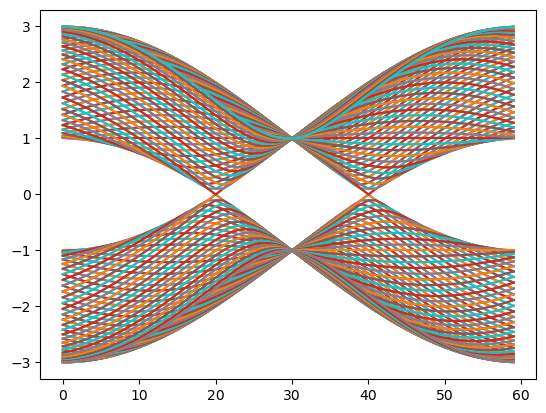

In [2]:
N_ks = 60  # number of k-points in each direction
N_k_axis = np.linspace(0, 2 * np.pi, N_ks, endpoint=False)
hamiltonians_0 = np.array(
    [[hamiltonian_return(kx, ky) for kx in N_k_axis] for ky in N_k_axis]
)

vals0, vecs0 = np.linalg.eigh(hamiltonians_0)
for i in range(len(vals0[:, 0, 0])):
    for j in range(4):
        plt.plot(vals0[i, :, j])

Now we need several helper functions to compute:
* the mean-field $F$ for each k-point
* the Fermi level based on the filling (we need to know what states will be occupied!)
* the convolution in k-space with periodic boundary conditions.
* convergence of the mean field
* energy per atom

In [3]:
def mean_field_F(vals, vecs, E_F=0):
    N_ks = vals.shape[0]

    def mf_generator(i, j):
        vals_i = vals[i, j, :]
        vecs_i = vecs[i, j, :, :]
        n_occ = vals_i < E_F
        occ_vecs = vecs_i[:, n_occ]
        F_ij = occ_vecs @ occ_vecs.conj().T
        return F_ij

    F = np.array([[mf_generator(i, j) for i in range(N_ks)] for j in range(N_ks)])
    return F


def get_fermi_energy(vals_flat, filling):
    ne = len(vals_flat)
    ifermi = int(round(ne * filling))  # index for fermi
    if ifermi >= ne:
        ifermi = ne - 1
    sorte = np.sort(vals_flat)  # sorted eigenvalues
    if ifermi == 0:
        return sorte[0]
    fermi = (sorte[ifermi - 1] + sorte[ifermi]) / 2.0  # fermi energy
    return fermi


from scipy.signal import convolve2d


def convolution(M1, M2):
    cell_size = V.shape[2]
    V_output = np.array(
        [
            [
                convolve2d(M1[:, :, i, j], M2[:, :, i, j], boundary="wrap", mode="same")
                for i in range(cell_size)
            ]
            for j in range(cell_size)
        ]
    )
    V_output = np.transpose(V_output, axes=(2, 3, 0, 1))
    return V_output


def dm(mf_new, mf):
    # relative convergence of the mean field
    mf_max = np.abs(np.max(np.concatenate((mf.flatten(), mf_new.flatten()))))
    delta = np.abs(mf_new - mf) / mf_max
    return np.max(delta)


def energy_per_atom(vals, E_F):
    N_filling = np.sum((vals < E_F).flatten())
    E_total = np.sum(vals[vals < E_F].flatten())
    E_p_atom = E_total / N_filling
    return E_p_atom

Now its time to spice it up - consider a simple onsite Coulomb interaction. We make it the same for all k-point since we are lazy, but in general, you would have to Fourier transform interaction into k-space:

In [4]:
U = 2.5
# we need block diagonal structure here since opposite spins interact on the same sublattice
v_int = U * np.block(
    [[np.ones((2, 2)), np.zeros((2, 2))], [np.zeros((2, 2)), np.ones((2, 2))]]
)
# repeat the matrix on a k-grid
V = np.array([[v_int for i in range(N_ks)] for j in range(N_ks)])
v_int

array([[2.5, 2.5, 0. , 0. ],
       [2.5, 2.5, 0. , 0. ],
       [0. , 0. , 2.5, 2.5],
       [0. , 0. , 2.5, 2.5]])

In [5]:
mixing = 0.6
threshold = 1e-3
for n in range(5000):
    if n == 0:
        mf = np.diag(np.random.rand(4)) - 0.5  # starting guess
        hamiltonians = hamiltonians_0 + mf
        vals, vecs = np.linalg.eigh(hamiltonians)
        E_F = get_fermi_energy(vals.flatten(), 0.5)
    F = mean_field_F(vals, vecs, E_F=E_F)
    rho = np.diag(np.average(F, axis=(0, 1)))
    exchange_mf = convolution(F, V) * N_ks ** (-2)  # exchange term
    direct_mf = np.diag(np.einsum("i,ij->j", rho, v_int))  # direct term

    mf_new = direct_mf - exchange_mf
    hamiltonians = hamiltonians_0 + mixing * mf_new + (1 - mixing) * mf

    vals, vecs = np.linalg.eigh(hamiltonians)
    E_F = get_fermi_energy(vals.flatten(), 0.5)
    delta_m = dm(mf_new, mf)
    if delta_m < threshold:
        print(f"Threshold reached in {n} steps")
        E_p_atom = energy_per_atom(vals, E_F)
        print(f"Energy per atom: {E_p_atom}")
        break
    print(f"{delta_m}", end="\r")
    mf = mf_new

Threshold reached in 51 steps
Energy per atom: -0.3494095226149221


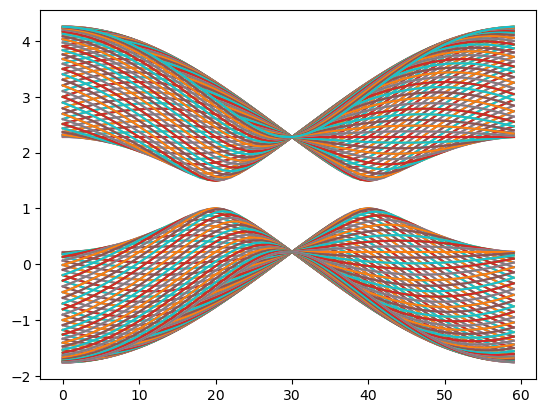

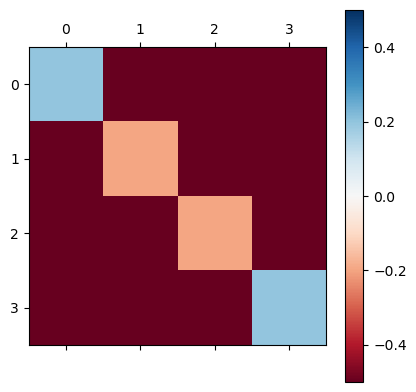

In [7]:
for i in range(len(vals[:,0,0])):
    for j in range(4):
        plt.plot(vals[i,:,j])
plt.show()
plt.matshow(np.real(mf[40,20,:,:])-E_F, cmap="RdBu", vmin=-0.5, vmax=0.5) # plotting the mean field
plt.colorbar()

According to [literature](https://theses.hal.science/tel-02930295v2/document), the critical value for phase transition is around $U=2.23t$, which is around what we get!

## Scaling of the algorithm

Lets say $M$ is the number of degrees of freedom within the unit cell, and $N$ is the number of k-points along a direction (we consider 2D problem here). Then the following steps limit the scaling of the algorithm:
* Eigenvalue problem for each k-point: $O(N^2 M^3)$.
* Convolution in k-space: $O(N^4 M^2)$. In this case, this is the most expensive step.

In [8]:
# experimental implementation of general Coulomb interaction in case we want to play around.
import scipy.constants as spc


def func_onsite(site, U):
    return U * np.ones((2, 2))


constant = (
    spc.physical_constants["fine-structure constant"][0] * spc.hbar * spc.c
)  # energy * distance
constant /= 2.8 * spc.e * 1.4 * spc.angstrom


def func_hop(site1, site2, U, r_TF):
    rij = np.linalg.norm(site1.pos - site2.pos)
    return (
        U
        * np.exp(-rij / r_TF)
        / np.sqrt(1 + (U * rij * constant) ** 2)
        * np.ones((2, 2))
    )


lattice = graphene
max_neighbor = 1
syst = wrapped_syst_unfinalized
V = kwant.Builder(kwant.TranslationalSymmetry(*lattice.prim_vecs))
V[syst.sites()] = func_onsite
for n in range(max_neighbor):
    V[lattice.neighbors(n + 1)] = func_hop
wrapped = kwant.wraparound.wraparound(V).finalized()


@np.vectorize
def compute_Vk(dummy_syst, kx, ky, params={}):
    V = dummy_syst.hamiltonian_submatrix(params={**params, **dict(k_x=kx, k_y=ky)})
    return V


def potential_to_hamiltonian(
    syst, lattice, func_onsite, func_hop, params, max_neighbor=2
):
    V = kwant.Builder(kwant.TranslationalSymmetry(*lattice.prim_vecs))
    V[syst.sites()] = func_onsite
    for n in range(max_neighbor):
        V[lattice.neighbors(n + 1)] = func_hop
    wrapped_V = kwant.wraparound.wraparound(V).finalized()
    return np.array(
        [
            [
                compute_Vk(dummy_syst=wrapped_V, kx=kx, ky=ky, params=params)
                for kx in N_k_axis
            ]
            for ky in N_k_axis
        ]
    )


U = 3

V = potential_to_hamiltonian(
    syst=wrapped_syst_unfinalized,
    lattice=graphene,
    func_onsite=func_onsite,
    func_hop=func_hop,
    params=dict(U=U, r_TF=1e-9),
)

# Getting the (0,0) component in k-space for direct interactions
V_direct = V[0, 0]